## Arabic-Handwritten-recognition using resnet-18

##### Info
Check GPU

In [1]:
#check GPU before we start
from pynvml import *
nvmlInit()
handle = nvmlDeviceGetHandleByIndex(0)
info = nvmlDeviceGetMemoryInfo(handle)
print("Total memory:", info.total)
print("Free memory:", info.free)
print("Used memory:", info.used)

Total memory: 2147483648
Free memory: 2107703296
Used memory: 39780352


##### Info
Incase you have more than one GPU devices. You can choose the GPU device you desire using the following command:

In [2]:
#choose the cuda device you want to utilize in this process
from numba import cuda
cuda.select_device(0)
cuda.close()

In [3]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
from fastai import *
from fastai.vision import *

##### Info
The following command should be excuted in case you want to use the CPU instead of the GPU. It is a slower process, but can handle bigger amount of data.
`defaults.device = torch.device('cpu')`

In this case it takes at least five times longer for each epoch, so I am not using it.

In [5]:
data_path = Path('data')
input_size = 64
batch_size = 32

1. We create an image databunch from the the (train/test) folders labeling each image using a regular expression to get the name of the letter from the file name.
2. For Data augmentaion we apply some random transformations to the images like (rotation,cropping) but we disable flipping the image as it is not useful in the case of characters.
3. We also normalize our images using the same stats from the Imagenet dataset.

In [6]:
arabic_labels = ['alef', 'beh', 'teh', 'theh', 'jeem', 'hah', 'khah', 'dal', 'thal',
                'reh', 'zain', 'seen', 'sheen', 'sad', 'dad', 'tah', 'zah', 'ain', 
                'ghain', 'feh', 'qaf', 'kaf', 'lam', 'meem', 'noon', 'heh', 'waw', 'yeh']
np.random.seed(42)
tfms = get_transforms(do_flip=False)
s = '([^/\d]+)\d+.jpg$'
data = (ImageList.from_folder(data_path)
        .split_by_rand_pct(0.2)
        .label_from_re(s,classes = arabic_labels)
        .transform(tfms,size=input_size)
        .databunch(bs=batch_size, num_workers=0)
        .normalize(imagenet_stats))

##### Info
In some cases we need to convert to dataset, we add the follwoing line to the previous code:
`.datasets()`
add a third test folder if needed:
`.add_test_folder()`

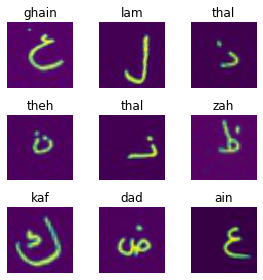

In [7]:
data.show_batch(rows=3, figsize=(4,4))

We build a pretrained CNN we then need to change the last part of the model to be adapted to our data. Most convolutional models end with a few linear layers (head). The last convolutional layer will have analyzed features in the image that went through the model, and the job of the head is to convert those in predictions for each of our classes. In transfer learning we will keep all the convolutional layers (backbone) with their weights pretrained on ImageNet but will define a new head initialized randomly.

`ResNet-18` is a convolutional neural network that is trained on more than a million images from the ImageNet database. The network is 18 layers deep and can classify images into 1000 object categories, such as keyboard, mouse, pencil, and many animals. As a result, the network has learned rich feature representations for a wide range of images. The network has an image input size of 224-by-224.[Source](https://www.mathworks.com/help/deeplearning/ref/resnet18.html)

In [8]:
#Use resnet18 model, bs = patch size. If you ran out of memory, just make it smaller, 32 is good for 8GB RAM.
learn = cnn_learner(data,models.resnet18,metrics=[accuracy, error_rate],pretrained=True).to_fp16()

There is an option to added the `.to_fp16()` to make it easier for cuda to handle the data and use bigger batch sizes. We might even get better generalization. Therefore, higher accuracy

### Stage 1: Train the head

In [9]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


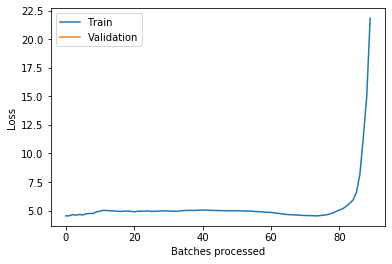

In [10]:
#The higher the batch size the higher the loss
learn.recorder.plot_losses()

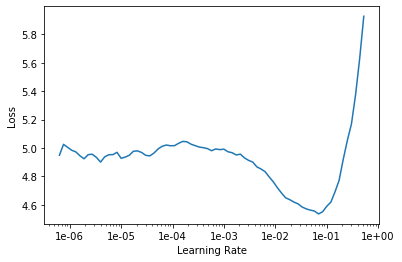

In [11]:
# Learning rate is derived from the slope where we can a clear stable decrease in the loss and usually 1e-3 is a good start for most models
learn.recorder.plot()

**We train the model we obtain in two phases:**
1. We freeze the body weights and only train the head (to convert those analyzed features into predictions for our own data).
2. We unfreeze the layers of the backbone and fine-tune the whole model

In [ ]:
#choose the learning rate from the strongest downward slope that is stable. A rule of thumb: the deep layers learning rate is 10 times lower than the shallow layers learning rate
learn.fit_one_cycle(12, slice(1e-2))

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,2.216748,1.406265,0.560714,0.439286,02:06
1,1.508005,0.898815,0.702083,0.297917,01:44
2,0.941015,0.550517,0.822619,0.177381,01:38
3,0.629859,0.349646,0.887500,0.112500,01:46
4,0.533300,0.278688,0.913690,0.086310,01:45
5,0.471578,0.247552,0.923810,0.076190,01:46
6,0.382199,0.195576,0.942262,0.057738,01:38
7,0.349987,0.193263,0.937202,0.062798,01:39


#### evaluate the primary model

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

In [ ]:
#see images with max loss
interp.plot_top_losses(6)

In [ ]:
#see images with max freqency of confussion
interp.most_confused(6)

In [ ]:
#in case we need to save the model
#learn.save('stage01-18')

### Stage 2: train the full body

In [ ]:
#unfreeze the deep layers, We trained the head and now we traing the full body
learn.unfreeze()

In [ ]:
#The fastest I can train this CNN at without making it zip off the rails and blown out. introduce a new learning rate.
learn.lr_find()

In [ ]:
# the learning rate
learn.recorder.plot()

In [ ]:
#fit a new model to train the deeper layers
learn.fit_one_cycle(5, max_lr=slice(1e-5,1e-4))

In this case we won't be able to get higher accuracy with this simple model so I will stop the process here.

In case we need to traing further, we can just repeat the same process from above.
Now we save our simple model for future use:

In [ ]:
learn.save('AHCR_Resnet-18_Final')

*Now we can take a look at the most incorrect images that our model has predicted.*

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

We can see that most of the images that our model got wrong are either very hard to recognize or labeled wrong.

In [ ]:
interp.plot_top_losses(6)

We check the most confused ones as well, means the highest number of the same wrong predicted item/s.

In [ ]:
interp.most_confused(6)

##### Info
We saved the model with fp16, then we have load it and rung with fp32 in order to avoid the following error `Input type (torch.cuda.FloatTensor) and weight type (torch.cuda.HalfTensor) should be the same`. We also use it as a chance to free up the memory used in order to further tune our model.

In [ ]:
tensor = learn.validate(data_test.valid_dl)

In [ ]:
tensor

In [ ]:
learn.show_results(9, figsize=(9,9))

In [ ]:
preds,y,losses = learn.get_preds(with_loss=True)
interp = ClassificationInterpretation(learn, preds, y, losses)
interp.plot_top_losses(9, figsize=(9,9))

In [ ]:
# get accuracy
acc = round(float(accuracy(preds, y))*100,2)
print('The accuracy is {0} %.'.format(acc))